In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [os.path.join(image_dir, file) for file in os.listdir(image_dir) if file.endswith('.tiff')]
        #we don't need to resize into 96*96 because we are doing that in below contrastive transform (self.resize_transform = transforms.resize((96,96)))
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")
        
        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0
        
        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)
        
        if self.transform:
            image1 = self.transform(image)
            image2 = self.transform(image)
        return image1, image2, image

# Data augmentation similar to the tutorial
contrast_transforms = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=96),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1)], p=0.8),
    #transforms.RandomGrayscale(p=0.2),
    #transforms.GaussianBlur(kernel_size=9),
])

# Create the dataset
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised\single_dose"

dataset = ImageDataset(image_dir=image_dir, transform=contrast_transforms)
batch_size = 16

# Function to split dataset with explicit percentage
def split_dataset(dataset, val_percentage):
    val_size = int(len(dataset) * val_percentage)
    train_size = len(dataset) - val_size
    return random_split(dataset, [train_size, val_size])

# Split the dataset with 20% for validation
val_percentage = 0.2
train_dataset, val_dataset = split_dataset(dataset, val_percentage)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0) #num_workers=os.cpu count() using cluster gpu
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

def compute_mean_std(dataloader):
    mean = 0.
    std = 0.
    nb_samples = 0.
    for images, _ in dataloader:
        batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
        images = images.view(batch_samples, images.size(1), -1)  # reshape to (N, C, H*W)
        mean += images.mean(2).mean(0)  # calculate mean per channel
        std += images.std(2).std(0)  # calculate std per channel
        nb_samples += batch_samples
    
    mean /= nb_samples
    std /= nb_samples
    return mean, std


In [5]:
for i, (image1, image2, image) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  Image1: {image1.shape}")
    print(f"  Image2: {image2.shape}")
    print(f"  image: {image.shape}")
    break

Batch 0:
  Image1: torch.Size([16, 3, 96, 96])
  Image2: torch.Size([16, 3, 96, 96])
  image: torch.Size([16, 3, 2054, 2456])


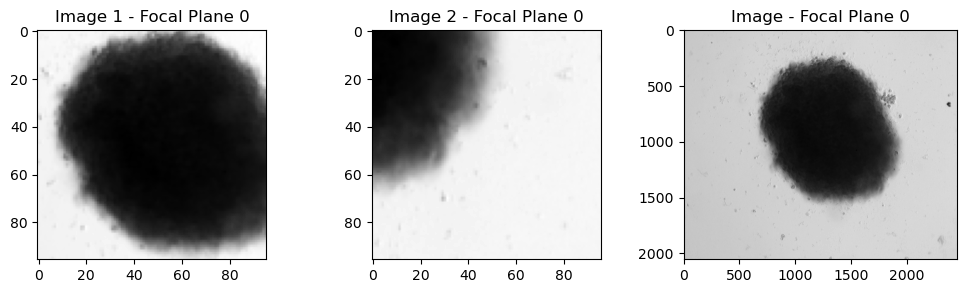

In [6]:
for i, (image1, image2, image) in enumerate(train_loader):
    # Select the first focal plane (layer) for visualization
    layer_to_visualize = 0  # Change this to 1 or 2 if you want other layers
    
    plt.figure(figsize=(10, 3))
    
    # Normalize the 16-bit image to range [0, 1] for visualization
    image1_normalized = image1[0, layer_to_visualize].float()
    image2_normalized = image2[0, layer_to_visualize].float()
    image_normalized = image[0, layer_to_visualize].float()
    
    # Plot Image1
    plt.subplot(1, 3, 1)
    plt.imshow(image1_normalized, cmap='gray')
    plt.title(f'Image 1 - Focal Plane {layer_to_visualize}')
    
    # Plot Image2
    plt.subplot(1, 3, 2)
    plt.imshow(image2_normalized, cmap='gray')
    plt.title(f'Image 2 - Focal Plane {layer_to_visualize}')
    
    # Plot Image
    plt.subplot(1, 3, 3)
    plt.imshow(image_normalized, cmap='gray')
    plt.title(f'Image - Focal Plane {layer_to_visualize}')
    
    plt.tight_layout()
    plt.show()
    break  # Exit after showing the first batch


# Load the pretrained UNet model
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)

In [7]:
class UNetEncoder(nn.Module):
    def __init__(self, unet_model,hidden_dim, lr, temperature, weight_decay, image_size=256, in_channel=3):
        super(UNetEncoder, self).__init__()
        self.image_size = image_size
        self.in_channel = in_channel
        self.temperature = temperature
        
        original_encoder1 = unet_model.encoder1
        
        # Create a new encoder1 layer with variable input channels, keeping the same output channels and kernel size
        self.encoder1 = nn.Sequential(
            nn.Conv2d(self.in_channel, original_encoder1[0].out_channels, 
                      kernel_size=original_encoder1[0].kernel_size, 
                      stride=original_encoder1[0].stride, 
                      padding=original_encoder1[0].padding),
            original_encoder1[1]  # Keep the rest of the layers (e.g., BatchNorm, ReLU) intact
        )
        
        self.pool1 = unet_model.pool1
        self.encoder2 = unet_model.encoder2
        self.pool2 = unet_model.pool2
        self.encoder3 = unet_model.encoder3
        self.pool3 = unet_model.pool3
        self.encoder4 = unet_model.encoder4
        self.pool4 = unet_model.pool4
        self.bottleneck = unet_model.bottleneck
        #dummy = torch.zeros((1, self.in_channel, image_size, image_size))
        #out = self.bottleneck(self.pool4(self.encoder4(self.pool3(self.encoder3(self.pool2(self.encoder2(self.pool1(self.encoder1(dummy)))))))))
        #shape = torch.flatten(out, start_dim=1).shape[1]
        #print(shape)
        #if I give shape instead of 18432 its shows mismatch between output of bottleneck and input of projection head. didn't figured it out why yet.
        
        # Define the fully connected layers after the bottleneck
        self.fc = nn.Sequential(
            nn.Linear(18432, 4 * hidden_dim),  # Adjust input size based on bottleneck output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        # Encoder with skip connections
        skip1 = self.encoder1(x)
        x = self.pool1(skip1)
        
        skip2 = self.encoder2(x)
        x = self.pool2(skip2)
        
        skip3 = self.encoder3(x)
        x = self.pool3(skip3)
        
        skip4 = self.encoder4(x)
        x = self.pool4(skip4)
        
        bottleneck = self.bottleneck(x)
        
        # Detach bottleneck and skip connections to save memory
        bottleneck = bottleneck.detach()
        skip1 = skip1.detach()
        skip2 = skip2.detach()
        skip3 = skip3.detach()
        skip4 = skip4.detach()
        
        # Flatten the bottleneck output for the fully connected layer
        bottleneck_flat = torch.flatten(bottleneck, start_dim=1)
        print(f"Flattened bottleneck shape: {bottleneck_flat.shape}")
        
        # Pass through the fully connected layers for training
        output = self.fc(bottleneck_flat)
        
        # Return output for training, and detached bottleneck + skip connections for later use
        return output, bottleneck, (skip1, skip2, skip3, skip4)


    
    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats,_,_ = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

class SimCLR(nn.Module):
    def __init__(self, hidden_dim, lr, temperature, weight_decay):
        super().__init__()
        self.temperature = temperature
        
        # Load the pretrained ResNet-18 model
        self.convnet = torchvision.models.resnet18(weights='ResNet18_Weights.DEFAULT')
        
        # Modify the fully connected layer
        self.convnet.fc = nn.Sequential(
            nn.Linear(self.convnet.fc.in_features, 4 * hidden_dim),  # Linear layer with 4*hidden_dim output
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, 20)  # Output layer with hidden_dim output
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        self.lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=50, eta_min=lr / 50)

    def forward(self, x):
        return self.convnet(x)

    def info_nce_loss(self, imgs1, imgs2, device):

        imgs = torch.cat((imgs1, imgs2), dim=0)  # Concatenate along the batch dimension
        imgs = imgs.to(device)  # Move images to the device

        # Encode all images
        feats = self.forward(imgs)
    
        # Calculate cosine similarity
        cos_sim = nn.functional.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)
    
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
    
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)
    
        # Normalize similarity scores by temperature
        cos_sim = cos_sim / self.temperature

        # InfoNCE loss
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Accuracy calculations
        # Create a combination of positive and negative similarities for ranking
        comb_sim = torch.cat([cos_sim[pos_mask][:, None],  # Positive example in first position
                          cos_sim.masked_fill(pos_mask, -9e15)], dim=-1)
    
        # Sort and get the ranking position of the positive example
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
    
        # Compute accuracy metrics
        top1_acc = (sim_argsort == 0).float().mean()  # Top-1 accuracy
        top5_acc = (sim_argsort < 5).float().mean()   # Top-5 accuracy
        mean_pos = 1 + sim_argsort.float().mean()     # Mean position of the positive example

        return nll, top1_acc, top5_acc, mean_pos

    def train_epoch(self, train_loader, device):
        self.train()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        for batch in tqdm(train_loader, desc="Training", leave=False):
            imgs1, imgs2, _ = batch
            imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device
        
            self.optimizer.zero_grad()

            # Calculate loss and accuracy metrics
            loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

            loss.backward()
            self.optimizer.step()
            self.lr_scheduler.step()

            # Accumulate metrics
            total_loss += loss.item()
            total_top1_acc += top1_acc.item()
            total_top5_acc += top5_acc.item()
            total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(train_loader)
        avg_top1_acc = total_top1_acc / len(train_loader)
        avg_top5_acc = total_top5_acc / len(train_loader)
        avg_mean_pos = total_mean_pos / len(train_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

    def validate_epoch(self, val_loader, device):
        self.eval()
        total_loss = 0.0
        total_top1_acc = 0.0
        total_top5_acc = 0.0
        total_mean_pos = 0.0

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating", leave=False):
                imgs1, imgs2, _ = batch
                imgs1, imgs2 = imgs1.to(device), imgs2.to(device)  # Move data to device

                # Calculate loss and accuracy metrics
                loss, top1_acc, top5_acc, mean_pos = self.info_nce_loss(imgs1, imgs2, device)

                # Accumulate metrics
                total_loss += loss.item()
                total_top1_acc += top1_acc.item()
                total_top5_acc += top5_acc.item()
                total_mean_pos += mean_pos.item()

        avg_loss = total_loss / len(val_loader)
        avg_top1_acc = total_top1_acc / len(val_loader)
        avg_top5_acc = total_top5_acc / len(val_loader)
        avg_mean_pos = total_mean_pos / len(val_loader)

        return avg_loss, avg_top1_acc, avg_top5_acc, avg_mean_pos

In [8]:
def plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos):
    epochs = range(1, len(train_losses) + 1)
    
    # Plot loss
    plt.figure(figsize=(16, 10))
    
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Top-1 accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_top1_accs, 'bo-', label='Training Top-1 Accuracy')
    plt.plot(epochs, val_top1_accs, 'ro-', label='Validation Top-1 Accuracy')
    plt.title('Training and Validation Top-1 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-1 Accuracy (%)')
    plt.legend()

    # Plot Top-5 accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_top5_accs, 'bo-', label='Training Top-5 Accuracy')
    plt.plot(epochs, val_top5_accs, 'ro-', label='Validation Top-5 Accuracy')
    plt.title('Training and Validation Top-5 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Top-5 Accuracy (%)')
    plt.legend()

    # Plot Mean Positive Position
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_mean_pos, 'bo-', label='Training Mean Positive Position')
    plt.plot(epochs, val_mean_pos, 'ro-', label='Validation Mean Positive Position')
    plt.title('Training and Validation Mean Positive Position')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Position')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [9]:
def train_simclr(batch_size, max_epochs=50, hidden_dim=128, lr=5e-4, temperature=0.07, weight_decay=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    # Load the pretrained UNet model
    model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                       in_channels=3, out_channels=1, init_features=32, pretrained=True)
    model = UNetEncoder(model,hidden_dim=hidden_dim,lr=lr, temperature=temperature, weight_decay=weight_decay,image_size=256, in_channel=3).to(device)
    
    # Lists to store the metrics
    train_losses, val_losses = [], []
    train_top1_accs, val_top1_accs = [], []
    train_top5_accs, val_top5_accs = [], []
    train_mean_pos, val_mean_pos = [], []

    start_time = time.time()

    for epoch in range(max_epochs):
        epoch_start_time = time.time()

        # Train and validate the model
        train_loss, train_top1_acc, train_top5_acc, train_mean_pos_val = model.train_epoch(train_loader, device)
        val_loss, val_top1_acc, val_top5_acc, val_mean_pos_val = model.validate_epoch(val_loader, device)
        
        # Store the metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_top1_accs.append(train_top1_acc)
        val_top1_accs.append(val_top1_acc)
        train_top5_accs.append(train_top5_acc)
        val_top5_accs.append(val_top5_acc)
        train_mean_pos.append(train_mean_pos_val)
        val_mean_pos.append(val_mean_pos_val)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        # Print metrics for the current epoch
        print(f"Epoch {epoch+1}/{max_epochs} | "
              f"Train Loss: {train_loss:.4f} | "
              f"Top-1 Acc: {train_top1_acc:.2f}% | Top-5 Acc: {train_top5_acc:.2f}% | "
              f"Mean Pos: {train_mean_pos_val:.2f} | "
              f"Val Loss: {val_loss:.4f} | Top-1 Acc: {val_top1_acc:.2f}% | "
              f"Top-5 Acc: {val_top5_acc:.2f}% | Mean Pos: {val_mean_pos_val:.2f} | "
              f"Time Taken: {epoch_duration:.2f} seconds")

    end_time = time.time()
    total_duration = end_time - start_time
    print(f"Total Training Time: {total_duration:.2f} seconds")

    # Plot results
    plot_curves(train_losses, val_losses, train_top1_accs, val_top1_accs, train_top5_accs, val_top5_accs, train_mean_pos, val_mean_pos)

    return model

Using device: cuda


Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master
Training:   0%|          | 0/2 [00:00<?, ?it/s]

Flattened bottleneck shape: torch.Size([32, 18432])


Flattened bottleneck shape: torch.Size([16, 18432])


Flattened bottleneck shape: torch.Size([12, 18432])
Epoch 1/1 | Train Loss: 3.5504 | Top-1 Acc: 0.08% | Top-5 Acc: 0.22% | Mean Pos: 11.73 | Val Loss: 2.3805 | Top-1 Acc: 0.33% | Top-5 Acc: 0.75% | Mean Pos: 3.50 | Time Taken: 2.67 seconds
Total Training Time: 2.67 seconds


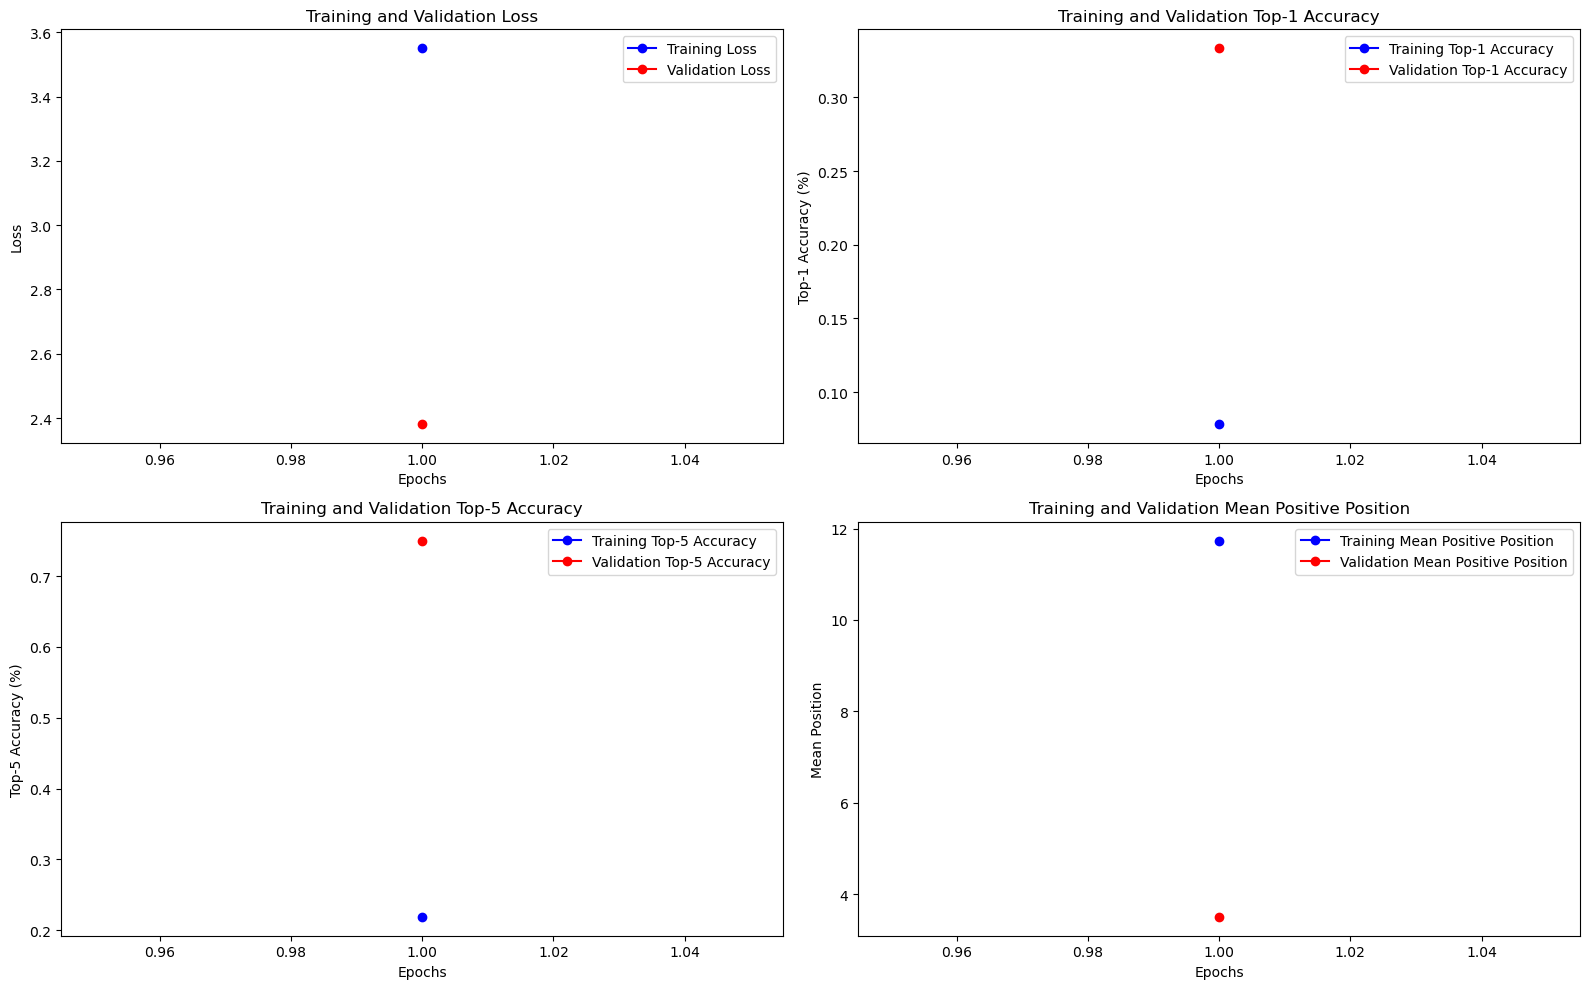

In [10]:
# Run the training script
simclr_model = train_simclr(batch_size=16, hidden_dim=96, lr=5e-4, temperature=0.07, weight_decay=1e-4, max_epochs=1)

# segmentation

In [11]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor
        image = torch.tensor(image, dtype=torch.float32)

        # Apply resize transform
        image = self.resize_transform(image)

        return image


def load_data(root_dir):
    classes = ['untreated', 'single_dose']
    image_files = []

    for class_name in classes:
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)

    return image_files


# Directory for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\Data_supervised"

# Load the data
image_files = load_data(image_dir)

# Create the dataset
train_dataset = LabeledImageDataset(image_files)

# Define the DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)


In [12]:
for anchor in train_loader:
    print(anchor.shape, anchor.dtype)
    break

torch.Size([16, 3, 96, 96]) torch.float32


In [13]:
@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model)
    network.fc = nn.Identity()  # Remove the fully connected layer
    network.eval()
    network.to(device)

    # Initialize storage for bottleneck features and skip connections
    bottleneck_feats_list = []
    skip_connections_list = []

    for batch_imgs in tqdm(dataloader, desc="Extracting Features"):
        # Directly move batch_imgs to the device
        batch_imgs = batch_imgs.to(device)

        # Unpack the outputs from the model
        _, bottleneck_feats, skip_connections = network(batch_imgs)  # Retrieve bottleneck and skips
        print(f"Batch bottleneck features shape: {bottleneck_feats.shape}")
        print(f"Batch skip connection shapes: {[s.shape for s in skip_connections]}")

        # Collect bottleneck features and skip connections
        bottleneck_feats_list.append(bottleneck_feats.cpu())
        skip_connections_list.append([s.cpu() for s in skip_connections])

    # Concatenate bottleneck features
    bottleneck_feats = torch.cat(bottleneck_feats_list, dim=0)
    print(f"Bottleneck features shape after concatenation: {bottleneck_feats.shape}")

    # Concatenate skip connections for each level
    skip_connections = [torch.cat([sc[i] for sc in skip_connections_list], dim=0) for i in range(len(skip_connections_list[0]))]
    print(f"Concatenated skip connection shapes: {[s.shape for s in skip_connections]}")

    return bottleneck_feats, skip_connections


@torch.no_grad()
def prepare_data_features(model, dataloader):
    # Prepare model
    network = deepcopy(model)
    network.fc = nn.Identity()  # Remove the fully connected layer
    network.eval()
    network.to(device)

    # Encode all images
    feats, labels = [], []
    for batch_imgs in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)

        # Unpack the outputs from the model
        _, bottleneck_feats = network(batch_imgs)  # Retrieve only bottleneck features
        print(f"Batch bottleneck features shape: {bottleneck_feats.shape}")
        
        
        # Collect bottleneck features and labels
        feats.append(bottleneck_feats.detach().cpu())
        

    # Concatenate all batches
    feats = torch.cat(feats, dim=0)
    
    
    print(f"Features shape after concatenation: {feats.shape}")
    

    return feats


In [14]:
# Extract features for train and test datasets
bottleneck_feats, skip_connections = prepare_data_features(simclr_model, train_loader)

Extracting Features:  25%|██▌       | 1/4 [00:00<00:02,  1.16it/s]

Flattened bottleneck shape: torch.Size([16, 18432])
Batch bottleneck features shape: torch.Size([16, 512, 6, 6])
Batch skip connection shapes: [torch.Size([16, 32, 96, 96]), torch.Size([16, 64, 48, 48]), torch.Size([16, 128, 24, 24]), torch.Size([16, 256, 12, 12])]


Extracting Features:  50%|█████     | 2/4 [00:01<00:01,  1.17it/s]

Flattened bottleneck shape: torch.Size([16, 18432])
Batch bottleneck features shape: torch.Size([16, 512, 6, 6])
Batch skip connection shapes: [torch.Size([16, 32, 96, 96]), torch.Size([16, 64, 48, 48]), torch.Size([16, 128, 24, 24]), torch.Size([16, 256, 12, 12])]


Extracting Features:  75%|███████▌  | 3/4 [00:02<00:00,  1.14it/s]

Flattened bottleneck shape: torch.Size([16, 18432])
Batch bottleneck features shape: torch.Size([16, 512, 6, 6])
Batch skip connection shapes: [torch.Size([16, 32, 96, 96]), torch.Size([16, 64, 48, 48]), torch.Size([16, 128, 24, 24]), torch.Size([16, 256, 12, 12])]


Extracting Features: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]

Flattened bottleneck shape: torch.Size([12, 18432])
Batch bottleneck features shape: torch.Size([12, 512, 6, 6])
Batch skip connection shapes: [torch.Size([12, 32, 96, 96]), torch.Size([12, 64, 48, 48]), torch.Size([12, 128, 24, 24]), torch.Size([12, 256, 12, 12])]
Bottleneck features shape after concatenation: torch.Size([60, 512, 6, 6])
Concatenated skip connection shapes: [torch.Size([60, 32, 96, 96]), torch.Size([60, 64, 48, 48]), torch.Size([60, 128, 24, 24]), torch.Size([60, 256, 12, 12])]


torch.save(feats_unet, 'features_unet.pt')

In [15]:
import torch
import torch.nn as nn

# Load the pretrained U-Net model
unet_model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', 
                             in_channels=3, out_channels=1, init_features=32, pretrained=True)

class UNetDecoderWithSkips(nn.Module):
    def __init__(self, unet_model):
        super(UNetDecoderWithSkips, self).__init__()
        self.decoder4 = unet_model.decoder4
        self.decoder3 = unet_model.decoder3
        self.decoder2 = unet_model.decoder2
        self.decoder1 = unet_model.decoder1
        self.conv = unet_model.conv

    def forward(self, bottleneck_feats, skip4, skip3, skip2, skip1):
        # Decoder with concatenation of skip connections
        x = self.decoder4(torch.cat([bottleneck_feats, skip4], dim=1))
        print(f"After decoder4: {x.shape}")
        
        x = self.decoder3(torch.cat([x, skip3], dim=1))
        print(f"After decoder3: {x.shape}")
        
        x = self.decoder2(torch.cat([x, skip2], dim=1))
        print(f"After decoder2: {x.shape}")
        
        x = self.decoder1(torch.cat([x, skip1], dim=1))
        print(f"After decoder1: {x.shape}")
        
        x = self.conv(x)
        print(f"After final conv: {x.shape}")
        return x



Using cache found in C:\Users\k54739/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


In [16]:

# Unpack the skip connections
skip1, skip2, skip3, skip4 = skip_connections
# Extract bottleneck features from feats_unet (shape: [Batch, 512, 6, 6])
decoder = UNetDecoderWithSkips(unet_model)

# Perform segmentation with skip connections
segmentation_output = decoder(bottleneck_feats, skip4, skip3, skip2, skip1) # Input shape: [Batch, 512, 6, 6]
print(f"Segmentation output shape: {segmentation_output.shape}")


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 6 but got size 12 for tensor number 1 in the list.